# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -f /content/drive/MyDrive/phlebology/image.py /usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py
!cp -f /content/drive/MyDrive/phlebology/image_data_generator.py /usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py

In [ ]:
cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
from sklearn.metrics import plot_confusion_matrix
from tensorflow.python.client import device_lib
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from numba import cuda

In [ ]:
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [ ]:
# set seed for results to be representative
torch.manual_seed(10)

In [ ]:
# Change everytime when you want to save net 
EPOCHS = 100
SAVE_BOOL = False
NAME = 'simple_aug_10_epochs_'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Useful Links 

# Loading data 

In [ ]:
def crop(X):
    res = np.zeros((len(X), len(X[0]), 300, 300))
    for p in range(len(X)):
        for s in range(len(X[p])):
            for i in range(106, 406):
                res[p][s][i - 106] = X[p][s][i][106:406]
    return res


# MRIs
X = np.load('data/small_data.npy')
X = crop(X)


# labels
y = pd.read_csv('data/all_target.csv')
y.columns = ['y']

# divide into 2 classes: no cut / cut - (0 / 1)
y = np.where(y.y <= 3, 0, 1)

In [ ]:
unique, counts = np.unique(y, return_counts=True)
counts = dict(zip(unique, counts))
print('percentage of 1: ', counts[1] / (counts[0] + counts[1]))
print('percentage of 0: ',  counts[0] / (counts[0] + counts[1]))

percentage of 1:  0.16049382716049382
percentage of 0:  0.8395061728395061


In [ ]:
X = torch.from_numpy(X).to(torch.float32).reshape((81, 10, 300, 300))
y = torch.tensor(y).reshape((-1, 1))
y = y.repeat_interleave(10)

In [ ]:
X = torch.reshape(X, (-1,))
X = torch.reshape(X, (810, 1, 300, 300))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_test, y_test)

train_dataloader = data_utils.DataLoader(train_dataset,
                                         batch_size=10,
                                         shuffle=True)
test_dataloader = data_utils.DataLoader(test_dataset,
                                         batch_size=10,
                                         shuffle=True)

In [ ]:
# pil_image = transforms.ToPILImage()(X_train[10])
# pil_image.show()

# Plot some fun

In [ ]:
def plot_image(train_dataloader):
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img)
    plt.show()
    print(f"Label: {label}")

In [ ]:
# for i in range(5):
#     plot_image(train_dataloader)

# Data Augmentation

In [ ]:
# Class for processing data

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


In [ ]:
# Let's add some transforms

# Dataset with flipping tranformations

def vflip(tensor):
    """Flips tensor vertically.
    """
    tensor = tensor.flip(1)
    return tensor


def hflip(tensor):
    """Flips tensor horizontally.
    """
    tensor = tensor.flip(2)
    return tensor

In [ ]:
all_datasets = []

In [ ]:
# Dataset w/o any tranformations
train_dataset_normal = CustomTensorDataset(tensors=(X_train, y_train), transform=None)
all_datasets.append(train_dataset_normal)
train_loader = torch.utils.data.DataLoader(train_dataset_normal, batch_size=16)
# plot_image(train_loader)

train_dataset_vf = CustomTensorDataset(tensors=(X_train, y_train), transform=vflip)
# all_datasets.append(train_dataset_vf)
train_loader = torch.utils.data.DataLoader(train_dataset_vf, batch_size=16)
# plot_image(train_loader)

train_dataset_hf = CustomTensorDataset(tensors=(X_train, y_train), transform=hflip)
# all_datasets.append(train_dataset_hf)
train_loader = torch.utils.data.DataLoader(train_dataset_hf, batch_size=16)   
# plot_image(train_loader)

In [ ]:
train_dataset = torch.utils.data.ConcatDataset(all_datasets)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16)

# Initializing net - baseline with simple data augmentation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [ ]:
default_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 2, kernel_size=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(p=0.2),
            nn.BatchNorm2d(2)
        )

In [ ]:
class my_net(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.cnn = net
        self.linear_layers = nn.Sequential(nn.Linear(19208, 2))

    # forward pass
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), 19208)
        x = self.linear_layers(x)
        return x

net = my_net(default_net)

In [ ]:
net.to(device)

my_net(
  (cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 2, kernel_size=(4, 4), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=19208, out_features=2, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
def learning_net(train_loader, net):
    for epoch in tqdm(range(EPOCHS)):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if i % 55 == 54:    # print every 100 mini-batches
                # print('[epoch: %d, %5d] loss: %.10f' %
                #       (epoch + 1, i + 1, running_loss / EPOCHS))
                running_loss = 0.0

    print('Your three hundred bucks, sir!')

In [ ]:
learning_net(train_loader, net)

100%|██████████| 100/100 [00:42<00:00,  2.36it/s]

Your three hundred bucks, sir!


In [ ]:
# saving net 

if SAVE_BOOL:
    PATH = f'{NAME}.pth'
    torch.save(net.state_dict(), PATH)

In [ ]:
def measure_accuracy(net, test_dataloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    print('Accuracy of the network on test images: %f %%' % (
        accuracy))
    return accuracy

In [ ]:
def predicting_test(test_dataloader):
    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in test_dataloader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

    # constant for classes
    classes = (0, 1)
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix), index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12, 7))
    sns.heatmap(df_cm, annot=True)
    cf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('Wrong predictions of 1 among all predictions of 1: ', cf_matrix[1][1] / (cf_matrix[0][1] + cf_matrix[1][1]))
    print('Wrong predictions where actual value is 1:', cf_matrix[1][0] / (cf_matrix[1][0] + cf_matrix[1][1]))
    print('F1 Score:', f1)
    print('Accuracy:', accuracy_score(y_true, y_pred))
    return y_true, y_pred
#     plt.savefig('output.png')

Wrong predictions of 1 among all predictions of 1:  0.5
Wrong predictions where actual value is 1: 0.9591836734693877
F1 Score: 0.07547169811320753
Accuracy: 0.8171641791044776


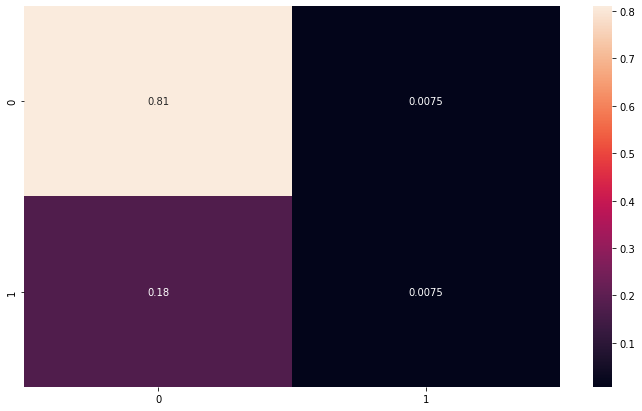

In [ ]:
y_true, y_pred = predicting_test(test_dataloader)
# measure_accuracy(net, test_dataloader)

So we see very bad prediction of minor class (1)

# Conducting experiments on the model's performance - trying to find the best architecture

In this block I will try to work on the proper CNN Architecture

In [ ]:
best_f_measure = 0
best_accuracy = 0

# !mkdir -p saved_model

In [ ]:
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4800420894276072043
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12744130560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1628574557232580239
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1


In [ ]:
def measure_quality(model, X_val2, Y_val2):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.333, random_state=0)
  global best_f_measure
  global best_accuracy
  classes = (0, 1)
  y_pred = model.predict(X_val2)
  y_pred = np.argmax(y_pred, axis=1)

  y_pred_anti_overfit = model.predict(X_test)
  y_pred_anti_overfit = np.argmax(y_pred_anti_overfit, axis=1)
  y_true_anti_overfit = y_test.argmax(axis=1)

  y_true = Y_val2.argmax(axis=1)
  cf_matrix = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cf_matrix.ravel()
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix), index = [i for i in classes],
                         columns = [i for i in classes])
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('Confusion Matrix');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values');

  ax.xaxis.set_ticklabels([0, 1])
  ax.yaxis.set_ticklabels([0, 1])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
  # plt.figure(figsize = (12, 7))
  # sn.heatmap(df_cm, annot=True)
  f1 = f1_score(y_true, y_pred, average='binary')
  print('Correct predictions of 1 among all predictions of 1: ', cf_matrix[1][1] / (cf_matrix[0][1] + cf_matrix[1][1]))
  print('Wrong predictions where actual value is 1(predicted 0 where should be 1):', cf_matrix[1][0] / (cf_matrix[1][0] + cf_matrix[1][1]))
  print('F1 Score:', f1)
  print('Accuracy:', accuracy_score(y_true, y_pred))

  print('Cross-validation')
  cf_matrix = confusion_matrix(y_true_anti_overfit, y_pred_anti_overfit)
  tn, fp, fn, tp = cf_matrix.ravel()
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix), index = [i for i in classes],
                         columns = [i for i in classes])
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('Confusion Matrix');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values');

  ax.xaxis.set_ticklabels([0, 1])
  ax.yaxis.set_ticklabels([0, 1])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
  # plt.figure(figsize = (12, 7))
  # sn.heatmap(df_cm, annot=True)
  f1 = f1_score(y_true_anti_overfit, y_pred_anti_overfit, average='binary')
  print('Correct predictions of 1 among all predictions of 1: ', cf_matrix[1][1] / (cf_matrix[0][1] + cf_matrix[1][1]))
  print('Wrong predictions where actual value is 1(predicted 0 where should be 1):', cf_matrix[1][0] / (cf_matrix[1][0] + cf_matrix[1][1]))
  print('F1 Score:', f1)
  print('Accuracy:', accuracy_score(y_true_anti_overfit, y_pred_anti_overfit))

  if f1 > best_f_measure and accuracy_score(y_true, y_pred) > best_accuracy:
    best_f_measure = f1
    best_accuracy = accuracy_score(y_true, y_pred)
    model.save('saved_model/best_model_overall')


  print('\n')

In [ ]:
# config = tf.ConfigProto( device_count = {'GPU': 1} ) 
# sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

In [ ]:
# MRIs
X = np.load('data/small_data.npy')
X = crop(X)


# labels
y = pd.read_csv('data/all_target.csv')
y.columns = ['y']

# divide into 2 classes: no cut / cut - (0 / 1)
y = np.where(y.y <= 3, 0, 1)

X = torch.from_numpy(X).to(torch.float32).reshape((81, 10, 300, 300))
y = torch.tensor(y).reshape((-1, 1))
y = y.repeat_interleave(10)

X = torch.reshape(X, (-1,))
X = torch.reshape(X, (810, 1, 300, 300))

X = X.cpu().detach().numpy()
y = y.cpu().detach().numpy()

# GLOBAL VARIABLES
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':', '-.', '--', '-', ':', '-.', '--', '-', ':', '-.', '--', '-']

In [ ]:
X_train = X_train.reshape(-1, 300, 300, 1)
X_test = X_test.reshape(-1, 300, 300, 1)
X = X.reshape(-1, 300, 300, 1)
X = X.reshape(-1, 300, 300, 1)
y = to_categorical(y, num_classes = 2)

## Experiment 1 - How many convolution-subsambling pairs?

24 48 64 96 128 192 256

In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] * nets

for j in range(nets):
    model[j] = Sequential()
    model[j].add(Conv2D(24, kernel_size=5, padding='same', activation='relu',
            input_shape=(300, 300, 1)))
    model[j].add(MaxPool2D())
    if j > 0:
        model[j].add(Conv2D(48, kernel_size=5, padding='same', activation='relu'))
        model[j].add(MaxPool2D())
    if j > 1:
        model[j].add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
        model[j].add(MaxPool2D())
    if j > 2:
        model[j].add(Conv2D(96, kernel_size=5, padding='same', activation='relu'))
        model[j].add(MaxPool2D())
    if j > 3:
        model[j].add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
        model[j].add(MaxPool2D())
    if j > 4:
        model[j].add(Conv2D(192, kernel_size=5, padding='same', activation='relu'))
        model[j].add(MaxPool2D())
    if j > 5:
        model[j].add(Conv2D(256, kernel_size=5, padding='same', activation='relu'))
        model[j].add(MaxPool2D())
    if j > 6:
        model[j].add(Conv2D(512, kernel_size=5, padding='same', activation='relu'))
        model[j].add(MaxPool2D(padding='same'))
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(2, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


0


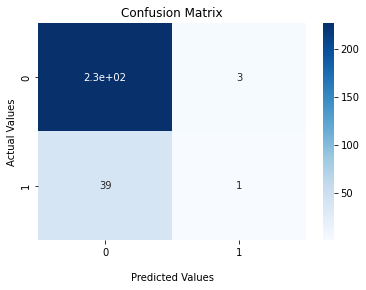

Correct predictions of 1 among all predictions of 1:  0.25
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.975
F1 Score: 0.045454545454545456
Accuracy: 0.8444444444444444
Cross-validation


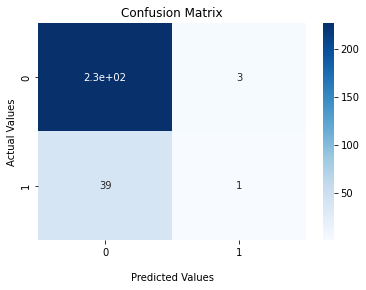

Correct predictions of 1 among all predictions of 1:  0.25
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.975
F1 Score: 0.045454545454545456
Accuracy: 0.8444444444444444
INFO:tensorflow:Assets written to: saved_model/best_model_overall/assets




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


1


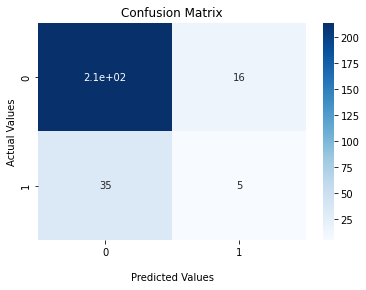

Correct predictions of 1 among all predictions of 1:  0.23809523809523808
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.875
F1 Score: 0.16393442622950818
Accuracy: 0.8111111111111111
Cross-validation


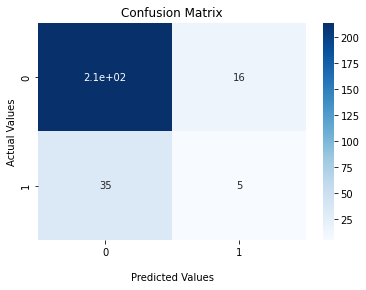

Correct predictions of 1 among all predictions of 1:  0.23809523809523808
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.875
F1 Score: 0.16393442622950818
Accuracy: 0.8111111111111111




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


2


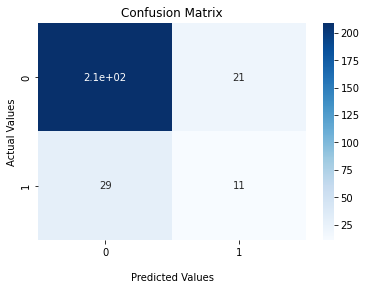

Correct predictions of 1 among all predictions of 1:  0.34375
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.3055555555555556
Accuracy: 0.8148148148148148
Cross-validation


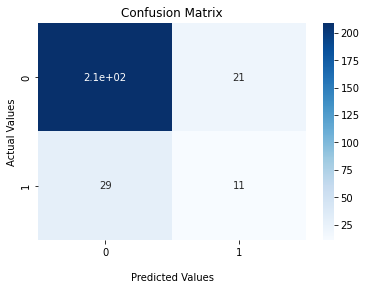

Correct predictions of 1 among all predictions of 1:  0.34375
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.3055555555555556
Accuracy: 0.8148148148148148




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


3


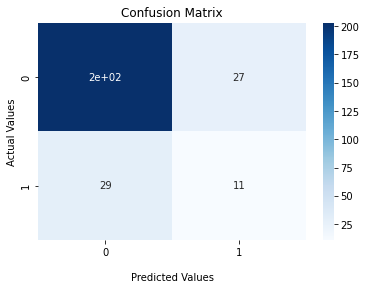

Correct predictions of 1 among all predictions of 1:  0.2894736842105263
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28205128205128205
Accuracy: 0.7925925925925926
Cross-validation


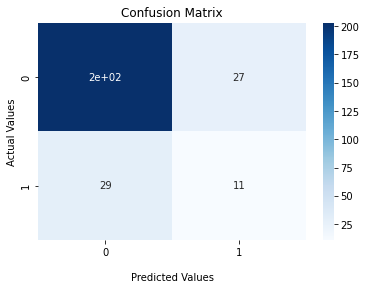

Correct predictions of 1 among all predictions of 1:  0.2894736842105263
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28205128205128205
Accuracy: 0.7925925925925926




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


4


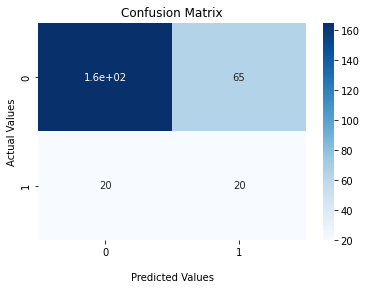

Correct predictions of 1 among all predictions of 1:  0.23529411764705882
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.5
F1 Score: 0.31999999999999995
Accuracy: 0.6851851851851852
Cross-validation


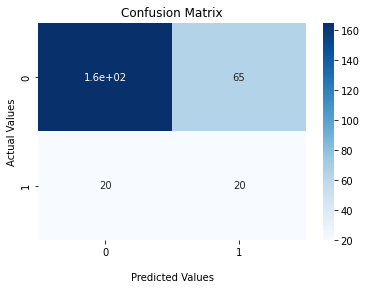

Correct predictions of 1 among all predictions of 1:  0.23529411764705882
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.5
F1 Score: 0.31999999999999995
Accuracy: 0.6851851851851852




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


5


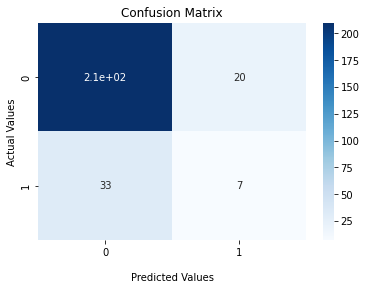

Correct predictions of 1 among all predictions of 1:  0.25925925925925924
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.825
F1 Score: 0.208955223880597
Accuracy: 0.8037037037037037
Cross-validation


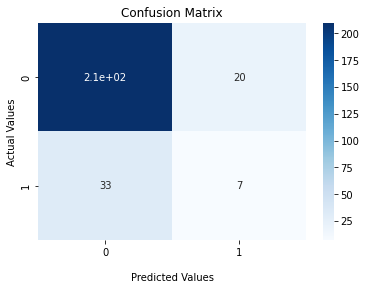

Correct predictions of 1 among all predictions of 1:  0.25925925925925924
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.825
F1 Score: 0.208955223880597
Accuracy: 0.8037037037037037




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


6


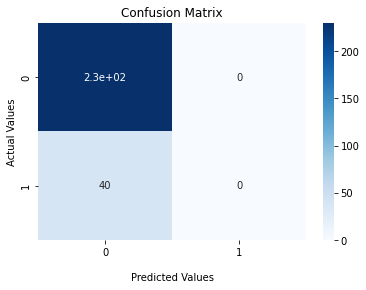

Correct predictions of 1 among all predictions of 1:  nan
Wrong predictions where actual value is 1(predicted 0 where should be 1): 1.0
F1 Score: 0.0
Accuracy: 0.8518518518518519
Cross-validation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars


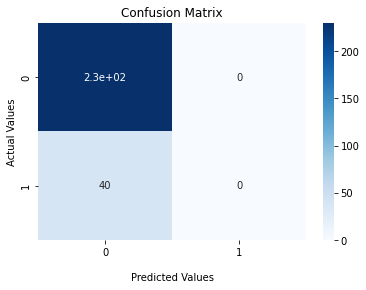

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Correct predictions of 1 among all predictions of 1:  nan
Wrong predictions where actual value is 1(predicted 0 where should be 1): 1.0
F1 Score: 0.0
Accuracy: 0.8518518518518519


7


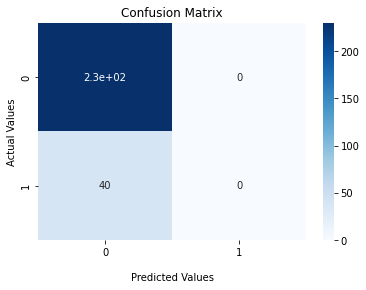

Correct predictions of 1 among all predictions of 1:  nan
Wrong predictions where actual value is 1(predicted 0 where should be 1): 1.0
F1 Score: 0.0
Accuracy: 0.8518518518518519
Cross-validation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars


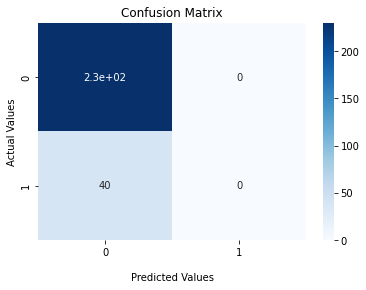

Correct predictions of 1 among all predictions of 1:  nan
Wrong predictions where actual value is 1(predicted 0 where should be 1): 1.0
F1 Score: 0.0
Accuracy: 0.8518518518518519




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.333, random_state=0)

datagen = ImageDataGenerator(contrast_stretching=True, adaptive_equalization=False, histogram_equalization=False)

# fit parameters from data
datagen.fit(X_train)

# TRAIN NETWORKS
history = [0] * nets
names = ["(C-P)x1", "(C-P)x2", "(C-P)x3", "(C-P)x4", "(C-P)x5", "(C-P)x6", "(C-P)x7", "(C-P)x8"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit_generator(datagen.flow(X_train, y_train, batch_size=25), epochs = epochs, 
                   validation_data = (X_test, y_test), callbacks=[annealer], verbose=0, shuffle=False)
    print(j)
    measure_quality(model[j], X_test, y_test)

So 3 Convolutiuonal layers is the best architecture (we have big enough picture for it)

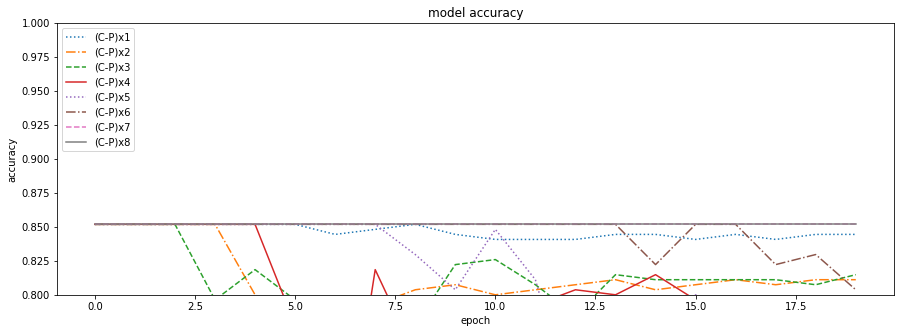

In [ ]:
# PLOT ACCURACIES
plt.figure(figsize=(15, 5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'], linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.8, 1])
plt.show()

## Experiment 2 - How many feature maps?

In [ ]:
# # BUILD CONVOLUTIONAL NEURAL NETWORKS
# nets = 5
# model = [0] * nets
# for j in range(nets):
#     model[j] = Sequential()
#     model[j].add(Conv2D(j*8+8, kernel_size=5, activation='relu',input_shape=(300, 300, 1)))
#     model[j].add(MaxPool2D())
#     model[j].add(Conv2D(j*16+16, kernel_size=5, activation='relu'))
#     model[j].add(MaxPool2D())
#     model[j].add(Conv2D(j*20+24, kernel_size=5, activation='relu'))
#     model[j].add(MaxPool2D())
#     model[j].add(Conv2D(j*32+32, kernel_size=5, activation='relu'))
#     model[j].add(MaxPool2D())
#     model[j].add(Conv2D(j*40+40, kernel_size=5, activation='relu'))
#     model[j].add(MaxPool2D())
#     model[j].add(Conv2D(j*48+48, kernel_size=5, activation='relu'))
#     model[j].add(MaxPool2D())
#     model[j].add(Conv2D(j*56+56, kernel_size=5, activation='relu'))
#     model[j].add(MaxPool2D())
#     model[j].add(Flatten())
#     model[j].add(Dense(256, activation='relu'))
#     model[j].add(Dense(2, activation='softmax'))
#     model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# # CREATE VALIDATION SET
# X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X, y, test_size = 0.333, random_state=42)
# # TRAIN NETWORKS
# history = [0] * nets
# names = ["8 maps", "16 maps", "24 maps", "32 maps", "48 maps", "64 maps"]
# epochs = 20
# for j in range(nets):
#     history[j] = model[j].fit(X_train2,Y_train2, batch_size=10, epochs = epochs, 
#         validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0, shuffle=False)
#     measure_quality(model[j], X_val2, Y_val2)

In [ ]:
# # PLOT ACCURACIES
# plt.figure(figsize=(15, 5))
# for i in range(nets):
#     plt.plot(history[i].history['val_accuracy'], linestyle=styles[i])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(names, loc='upper left')
# axes = plt.gca()
# axes.set_ylim([0.7, 1])
# plt.show()

So we take j = 0

## Experiment 3 - How large a dense layer?

In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 6
model = [0] * nets

for j in range(nets):
    model[j] = Sequential()
    model[j].add(Conv2D(24, kernel_size=5, activation='relu',input_shape=(300, 300, 1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(48, kernel_size=5, activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(64, kernel_size=5, activation='relu'))
    model[j].add(MaxPool2D(padding='same'))
    model[j].add(Flatten())
    if j > 0:
        model[j].add(Dense(2 ** (j + 4), activation='relu'))
    model[j].add(Dense(2, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


0


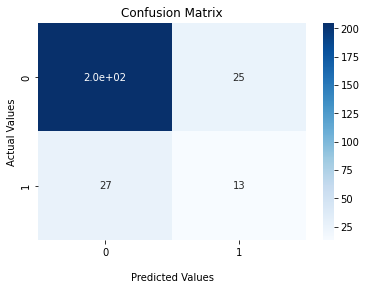

Correct predictions of 1 among all predictions of 1:  0.34210526315789475
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.675
F1 Score: 0.33333333333333337
Accuracy: 0.8074074074074075
Cross-validation


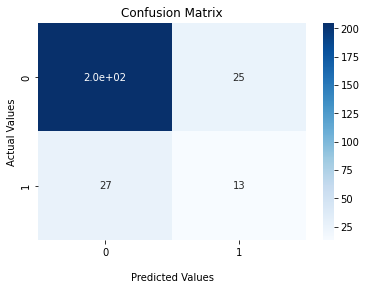

Correct predictions of 1 among all predictions of 1:  0.34210526315789475
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.675
F1 Score: 0.33333333333333337
Accuracy: 0.8074074074074075




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


1


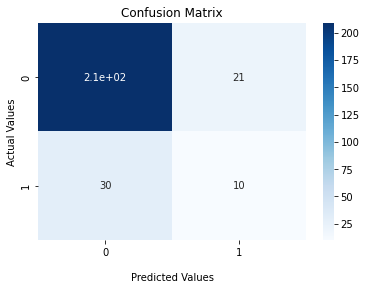

Correct predictions of 1 among all predictions of 1:  0.3225806451612903
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.28169014084507044
Accuracy: 0.8111111111111111
Cross-validation


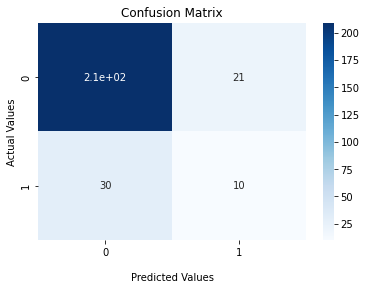

Correct predictions of 1 among all predictions of 1:  0.3225806451612903
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.28169014084507044
Accuracy: 0.8111111111111111




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


2


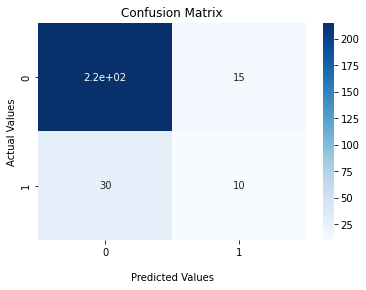

Correct predictions of 1 among all predictions of 1:  0.4
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.3076923076923077
Accuracy: 0.8333333333333334
Cross-validation


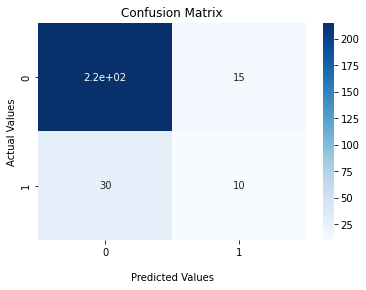

Correct predictions of 1 among all predictions of 1:  0.4
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.3076923076923077
Accuracy: 0.8333333333333334




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


3


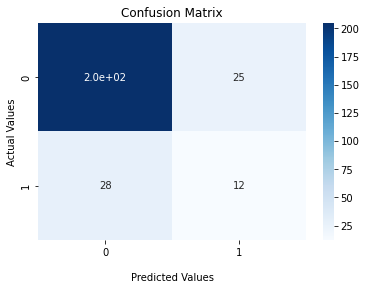

Correct predictions of 1 among all predictions of 1:  0.32432432432432434
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.3116883116883117
Accuracy: 0.8037037037037037
Cross-validation


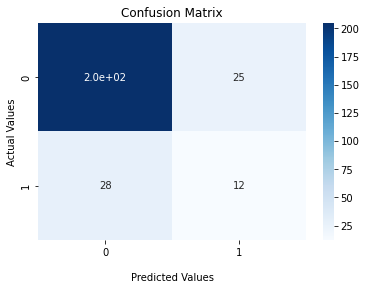

Correct predictions of 1 among all predictions of 1:  0.32432432432432434
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.3116883116883117
Accuracy: 0.8037037037037037




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


4


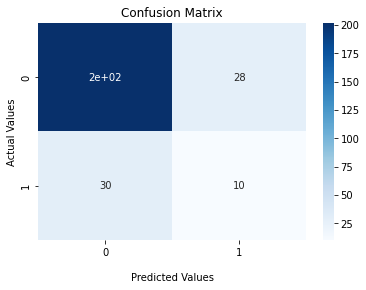

Correct predictions of 1 among all predictions of 1:  0.2631578947368421
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.25641025641025644
Accuracy: 0.7851851851851852
Cross-validation


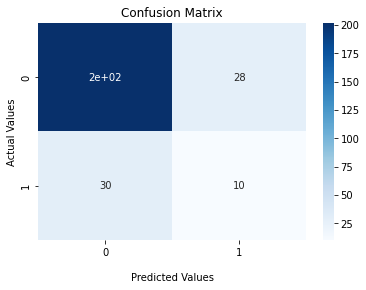

Correct predictions of 1 among all predictions of 1:  0.2631578947368421
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.25641025641025644
Accuracy: 0.7851851851851852




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


5


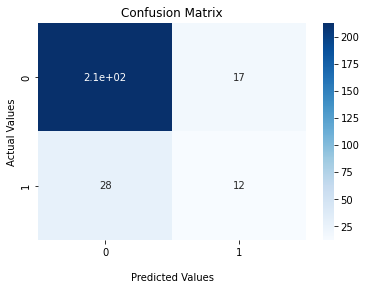

Correct predictions of 1 among all predictions of 1:  0.41379310344827586
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.34782608695652173
Accuracy: 0.8333333333333334
Cross-validation


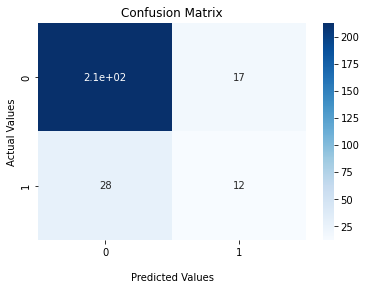

Correct predictions of 1 among all predictions of 1:  0.41379310344827586
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.34782608695652173
Accuracy: 0.8333333333333334




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.333, random_state=0)

datagen = ImageDataGenerator(contrast_stretching=True, adaptive_equalization=False, histogram_equalization=False)

# fit parameters from data
datagen.fit(X_train)

history = [0] * nets
names = ["0N","32N","64N","128N","256N","512N","1024N","2048N"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit_generator(datagen.flow(X_train, y_train, batch_size=25), epochs = epochs, 
                   validation_data = (X_test, y_test), callbacks=[annealer], verbose=0, shuffle=False)
    print(j)
    measure_quality(model[j], X_test, y_test)

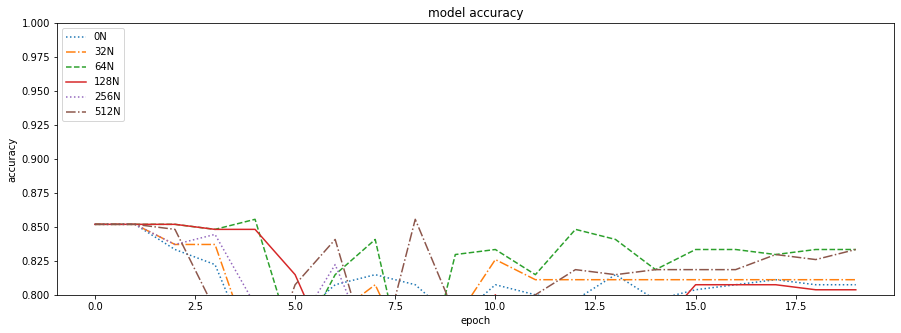

In [ ]:
# PLOT ACCURACIES
plt.figure(figsize=(15, 5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'], linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.8, 1])
plt.show()

So 256 or 512 in dense layer

## Experiment 4 - How much dropout?

In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] * nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(24, kernel_size=5, activation='relu',input_shape=(300, 300, 1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(48, kernel_size=5, activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(64, kernel_size=5, activation='relu'))
    # model[j].add(MaxPool2D())
    # model[j].add(Conv2D(96, kernel_size=5, activation='relu'))
    # model[j].add(MaxPool2D())
    # model[j].add(Conv2D(128, kernel_size=5, activation='relu'))
    # model[j].add(MaxPool2D())
    # model[j].add(Conv2D(192, kernel_size=5, activation='relu'))
    model[j].add(MaxPool2D(padding='same'))
    model[j].add(Flatten())
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(j * 0.1))
    model[j].add(Dense(2, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


0


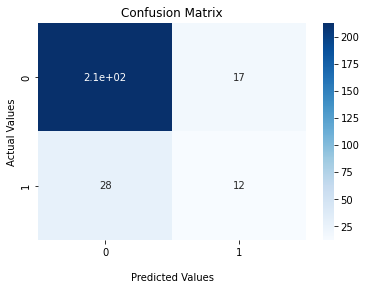

Correct predictions of 1 among all predictions of 1:  0.41379310344827586
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.34782608695652173
Accuracy: 0.8333333333333334
Cross-validation


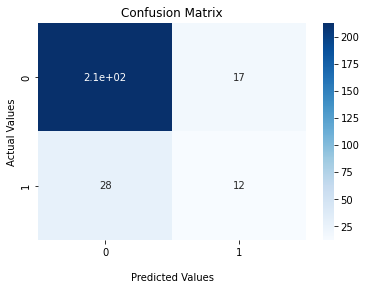

Correct predictions of 1 among all predictions of 1:  0.41379310344827586
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.34782608695652173
Accuracy: 0.8333333333333334




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


1


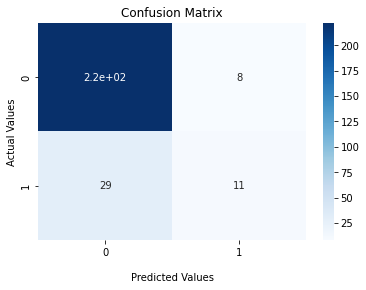

Correct predictions of 1 among all predictions of 1:  0.5789473684210527
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.37288135593220345
Accuracy: 0.8629629629629629
Cross-validation


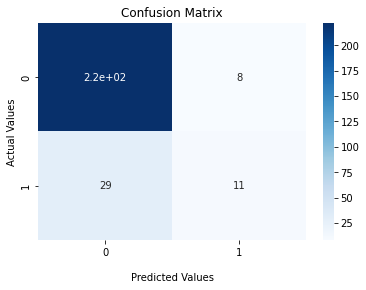

Correct predictions of 1 among all predictions of 1:  0.5789473684210527
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.37288135593220345
Accuracy: 0.8629629629629629
INFO:tensorflow:Assets written to: saved_model/best_model_overall/assets




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


2


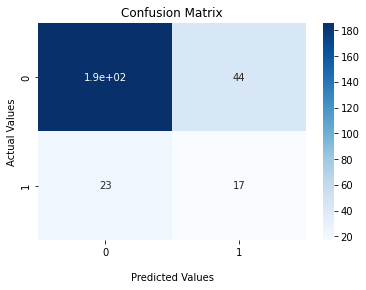

Correct predictions of 1 among all predictions of 1:  0.2786885245901639
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.575
F1 Score: 0.33663366336633666
Accuracy: 0.7518518518518519
Cross-validation


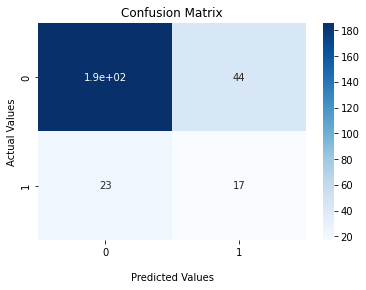

Correct predictions of 1 among all predictions of 1:  0.2786885245901639
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.575
F1 Score: 0.33663366336633666
Accuracy: 0.7518518518518519




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


3


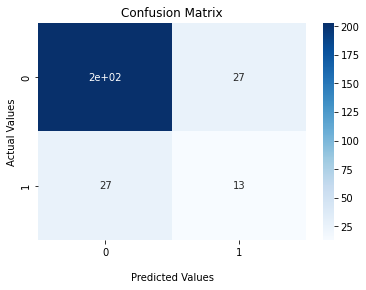

Correct predictions of 1 among all predictions of 1:  0.325
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.675
F1 Score: 0.325
Accuracy: 0.8
Cross-validation


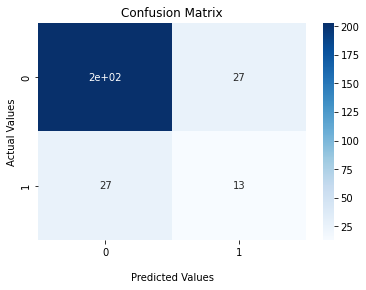

Correct predictions of 1 among all predictions of 1:  0.325
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.675
F1 Score: 0.325
Accuracy: 0.8




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


4


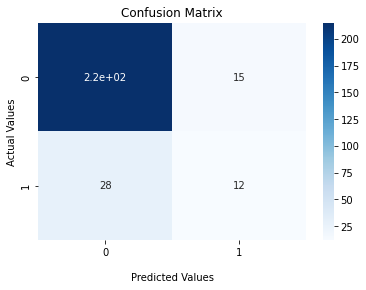

Correct predictions of 1 among all predictions of 1:  0.4444444444444444
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.3582089552238806
Accuracy: 0.8407407407407408
Cross-validation


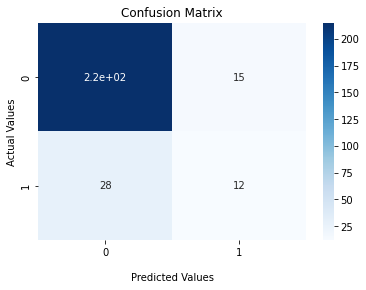

Correct predictions of 1 among all predictions of 1:  0.4444444444444444
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.3582089552238806
Accuracy: 0.8407407407407408




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


5


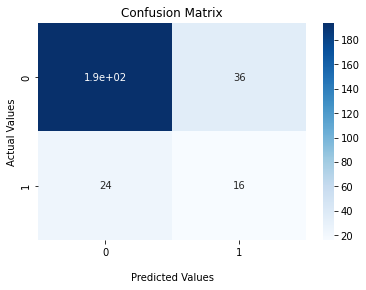

Correct predictions of 1 among all predictions of 1:  0.3076923076923077
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.6
F1 Score: 0.34782608695652173
Accuracy: 0.7777777777777778
Cross-validation


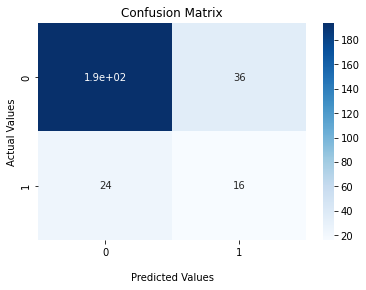

Correct predictions of 1 among all predictions of 1:  0.3076923076923077
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.6
F1 Score: 0.34782608695652173
Accuracy: 0.7777777777777778




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


6


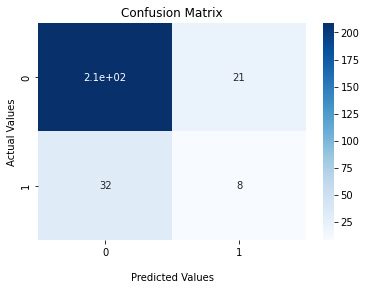

Correct predictions of 1 among all predictions of 1:  0.27586206896551724
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.8
F1 Score: 0.2318840579710145
Accuracy: 0.8037037037037037
Cross-validation


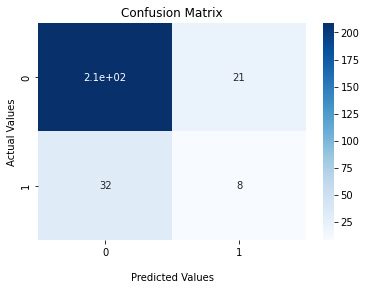

Correct predictions of 1 among all predictions of 1:  0.27586206896551724
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.8
F1 Score: 0.2318840579710145
Accuracy: 0.8037037037037037




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


7


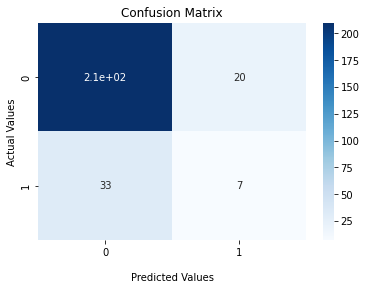

Correct predictions of 1 among all predictions of 1:  0.25925925925925924
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.825
F1 Score: 0.208955223880597
Accuracy: 0.8037037037037037
Cross-validation


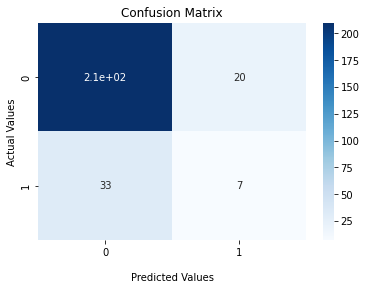

Correct predictions of 1 among all predictions of 1:  0.25925925925925924
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.825
F1 Score: 0.208955223880597
Accuracy: 0.8037037037037037




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.333, random_state=0)

datagen = ImageDataGenerator(contrast_stretching=True, adaptive_equalization=False, histogram_equalization=False)

# fit parameters from data
datagen.fit(X_train)

history = [0] * nets
names = ["D=0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit_generator(datagen.flow(X_train, y_train, batch_size=25), epochs = epochs, 
                   validation_data = (X_test, y_test), callbacks=[annealer], verbose=0, shuffle=False)
    print(j)
    measure_quality(model[j], X_test, y_test)

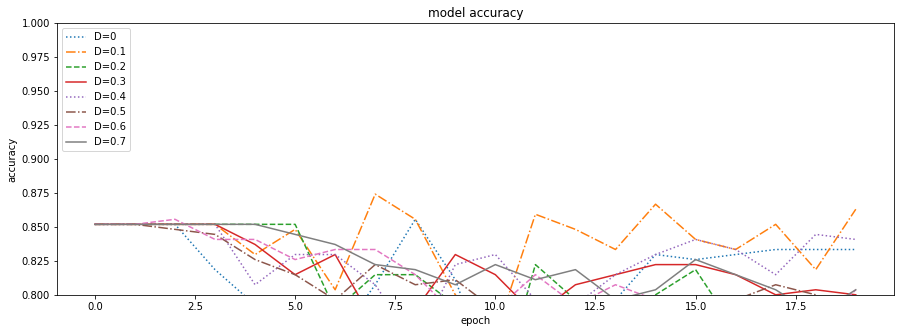

In [ ]:
# PLOT ACCURACIES
plt.figure(figsize=(15, 5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'], linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.8, 1])
plt.show()

So no dropout or 0.7

## Experiment 5 - epochs 

In [ ]:
model = Sequential()
model.add(Conv2D(24, kernel_size=5, activation='relu',input_shape=(300, 300, 1)))
model.add(MaxPool2D())
model.add(Conv2D(48, kernel_size=5, activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=5, activation='relu'))
# model.add(MaxPool2D())
# model.add(Conv2D(96, kernel_size=5, activation='relu'))
# model.add(MaxPool2D())
# model.add(Conv2D(128, kernel_size=5, activation='relu'))
# model.add(MaxPool2D())
# model.add(Conv2D(192, kernel_size=5, activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


0


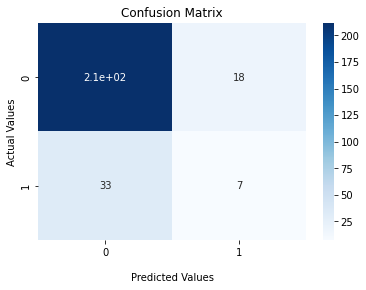

Correct predictions of 1 among all predictions of 1:  0.28
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.825
F1 Score: 0.2153846153846154
Accuracy: 0.8111111111111111
Cross-validation


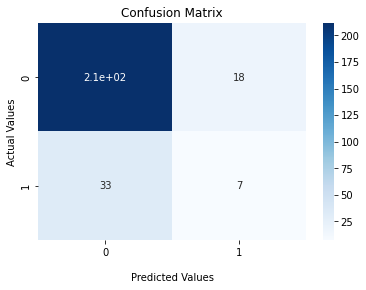

Correct predictions of 1 among all predictions of 1:  0.28
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.825
F1 Score: 0.2153846153846154
Accuracy: 0.8111111111111111




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


1


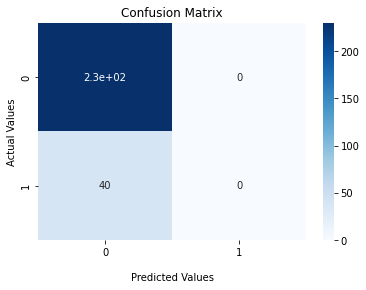

Correct predictions of 1 among all predictions of 1:  nan
Wrong predictions where actual value is 1(predicted 0 where should be 1): 1.0
F1 Score: 0.0
Accuracy: 0.8518518518518519
Cross-validation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars


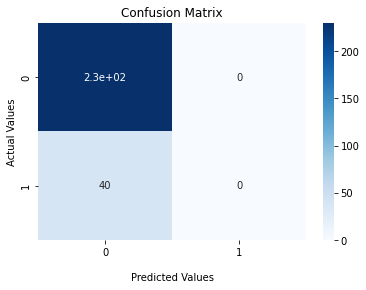

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Correct predictions of 1 among all predictions of 1:  nan
Wrong predictions where actual value is 1(predicted 0 where should be 1): 1.0
F1 Score: 0.0
Accuracy: 0.8518518518518519


2


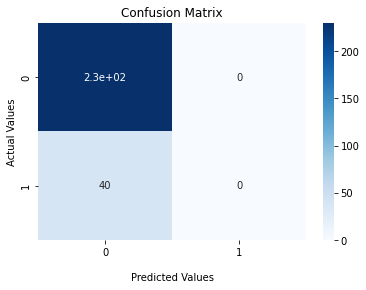

Correct predictions of 1 among all predictions of 1:  nan
Wrong predictions where actual value is 1(predicted 0 where should be 1): 1.0
F1 Score: 0.0
Accuracy: 0.8518518518518519
Cross-validation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars


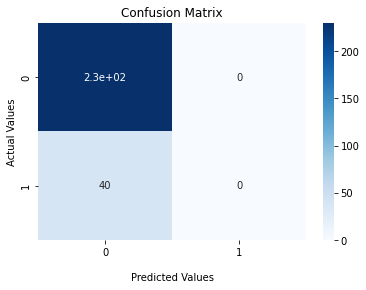

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Correct predictions of 1 among all predictions of 1:  nan
Wrong predictions where actual value is 1(predicted 0 where should be 1): 1.0
F1 Score: 0.0
Accuracy: 0.8518518518518519


3


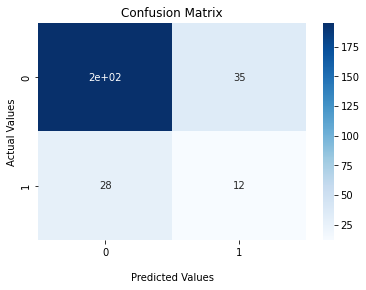

Correct predictions of 1 among all predictions of 1:  0.2553191489361702
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.2758620689655172
Accuracy: 0.7666666666666667
Cross-validation


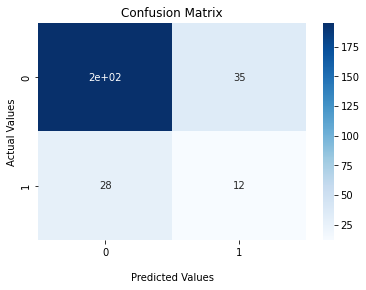

Correct predictions of 1 among all predictions of 1:  0.2553191489361702
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.7
F1 Score: 0.2758620689655172
Accuracy: 0.7666666666666667




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


4


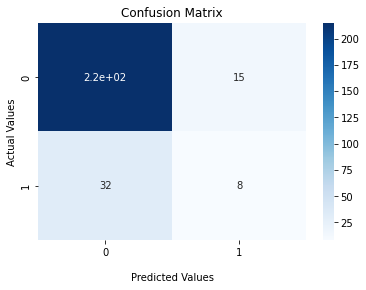

Correct predictions of 1 among all predictions of 1:  0.34782608695652173
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.8
F1 Score: 0.253968253968254
Accuracy: 0.825925925925926
Cross-validation


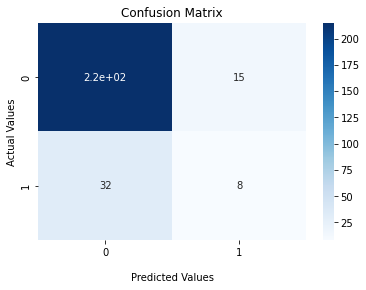

Correct predictions of 1 among all predictions of 1:  0.34782608695652173
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.8
F1 Score: 0.253968253968254
Accuracy: 0.825925925925926




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


5


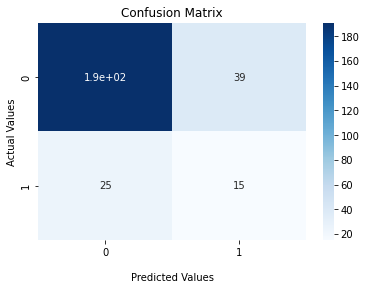

Correct predictions of 1 among all predictions of 1:  0.2777777777777778
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.625
F1 Score: 0.3191489361702128
Accuracy: 0.762962962962963
Cross-validation


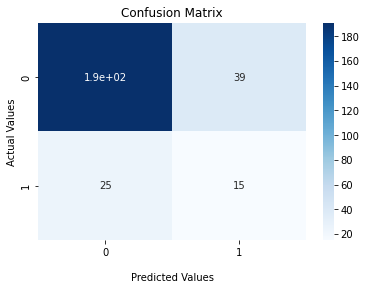

Correct predictions of 1 among all predictions of 1:  0.2777777777777778
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.625
F1 Score: 0.3191489361702128
Accuracy: 0.762962962962963




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


6


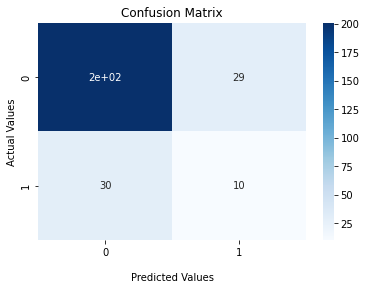

Correct predictions of 1 among all predictions of 1:  0.2564102564102564
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.2531645569620253
Accuracy: 0.7814814814814814
Cross-validation


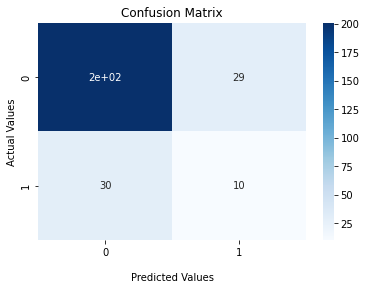

Correct predictions of 1 among all predictions of 1:  0.2564102564102564
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.2531645569620253
Accuracy: 0.7814814814814814




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


7


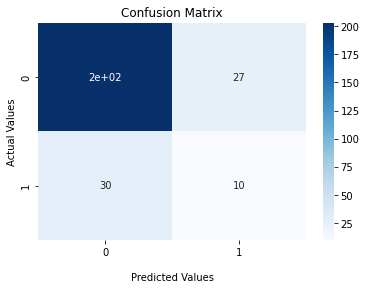

Correct predictions of 1 among all predictions of 1:  0.2702702702702703
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.25974025974025977
Accuracy: 0.7888888888888889
Cross-validation


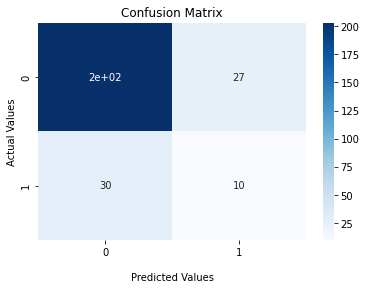

Correct predictions of 1 among all predictions of 1:  0.2702702702702703
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.25974025974025977
Accuracy: 0.7888888888888889




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


8


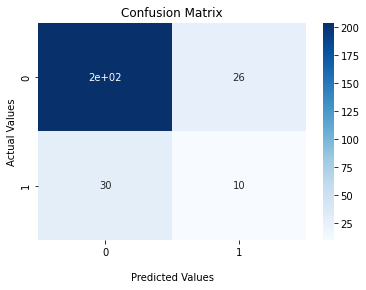

Correct predictions of 1 among all predictions of 1:  0.2777777777777778
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.2631578947368421
Accuracy: 0.7925925925925926
Cross-validation


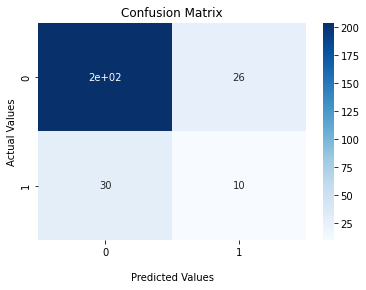

Correct predictions of 1 among all predictions of 1:  0.2777777777777778
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.2631578947368421
Accuracy: 0.7925925925925926




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


9


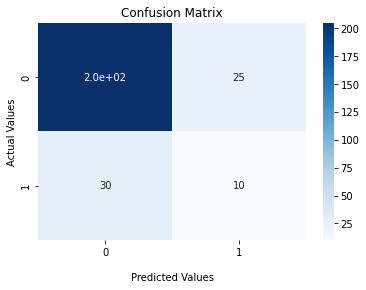

Correct predictions of 1 among all predictions of 1:  0.2857142857142857
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.26666666666666666
Accuracy: 0.7962962962962963
Cross-validation


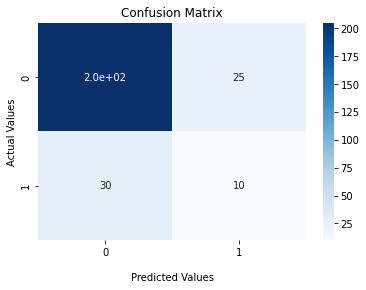

Correct predictions of 1 among all predictions of 1:  0.2857142857142857
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.26666666666666666
Accuracy: 0.7962962962962963




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


10


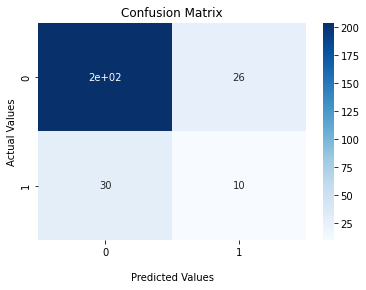

Correct predictions of 1 among all predictions of 1:  0.2777777777777778
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.2631578947368421
Accuracy: 0.7925925925925926
Cross-validation


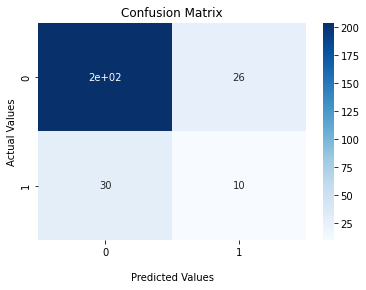

Correct predictions of 1 among all predictions of 1:  0.2777777777777778
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.75
F1 Score: 0.2631578947368421
Accuracy: 0.7925925925925926




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


11


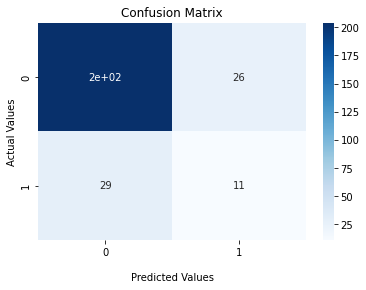

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963
Cross-validation


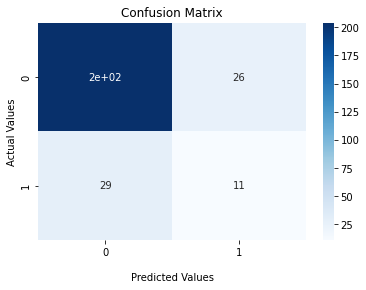

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


12


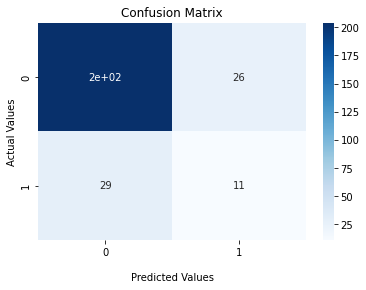

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963
Cross-validation


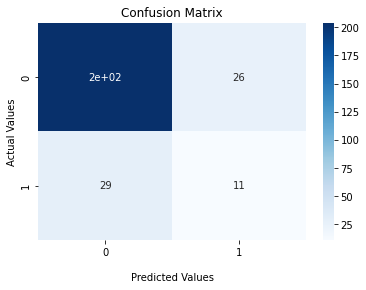

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


13


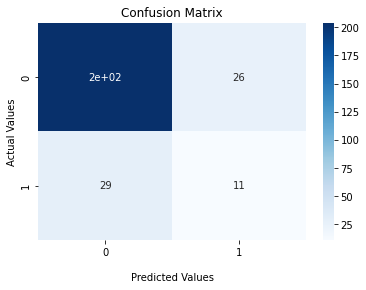

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963
Cross-validation


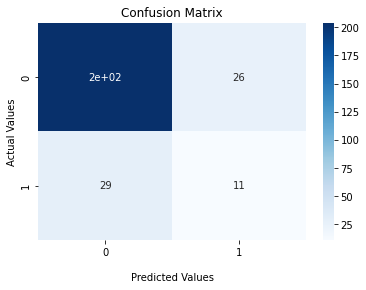

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


14


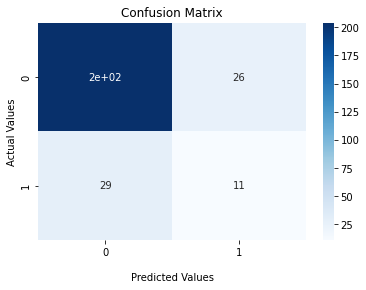

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963
Cross-validation


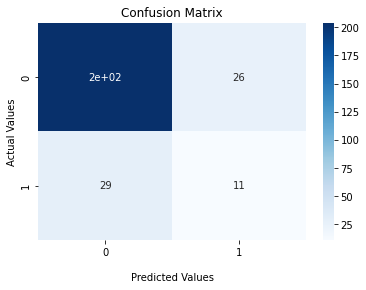

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


15


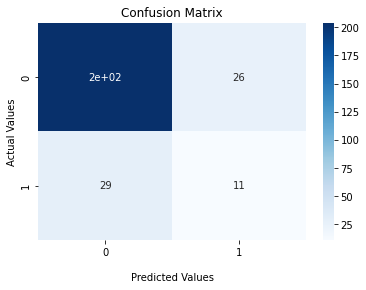

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963
Cross-validation


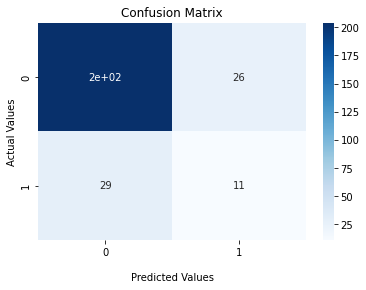

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


16


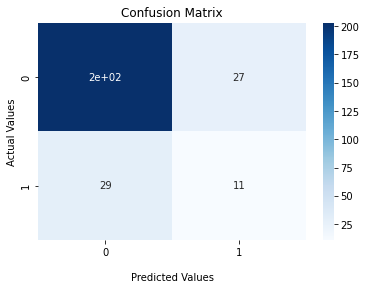

Correct predictions of 1 among all predictions of 1:  0.2894736842105263
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28205128205128205
Accuracy: 0.7925925925925926
Cross-validation


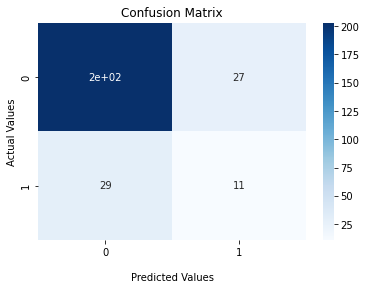

Correct predictions of 1 among all predictions of 1:  0.2894736842105263
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28205128205128205
Accuracy: 0.7925925925925926




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


17


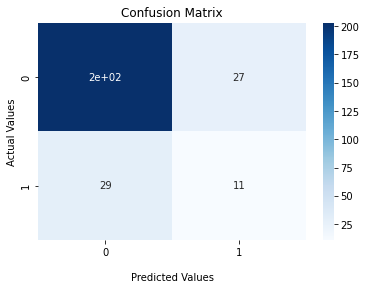

Correct predictions of 1 among all predictions of 1:  0.2894736842105263
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28205128205128205
Accuracy: 0.7925925925925926
Cross-validation


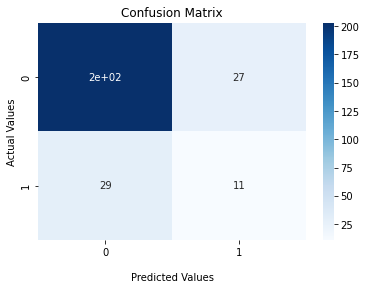

Correct predictions of 1 among all predictions of 1:  0.2894736842105263
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28205128205128205
Accuracy: 0.7925925925925926




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


18


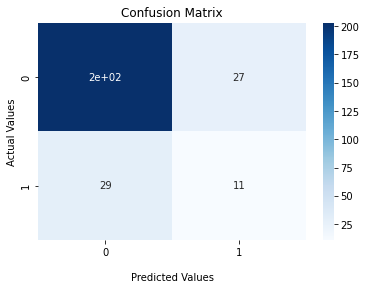

Correct predictions of 1 among all predictions of 1:  0.2894736842105263
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28205128205128205
Accuracy: 0.7925925925925926
Cross-validation


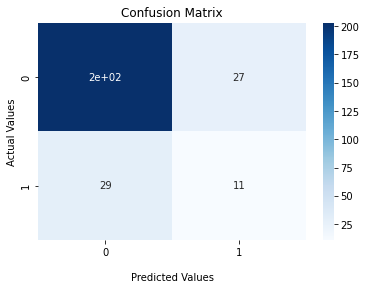

Correct predictions of 1 among all predictions of 1:  0.2894736842105263
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28205128205128205
Accuracy: 0.7925925925925926




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


19


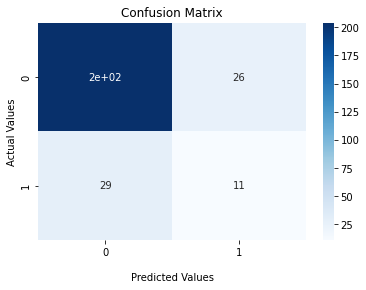

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963
Cross-validation


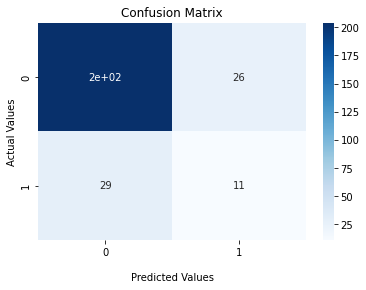

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


20


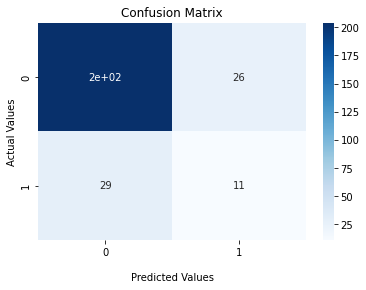

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963
Cross-validation


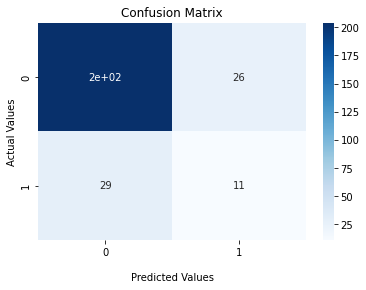

Correct predictions of 1 among all predictions of 1:  0.2972972972972973
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.725
F1 Score: 0.28571428571428575
Accuracy: 0.7962962962962963




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.333, random_state=0)

datagen = ImageDataGenerator(contrast_stretching=True, adaptive_equalization=False, histogram_equalization=False)

# fit parameters from data
datagen.fit(X_train)

for epochs in range(21):
    fitted = model.fit_generator(datagen.flow(X_train, y_train, batch_size=25), epochs = epochs, 
                   validation_data = (X_test, y_test), callbacks=[annealer], verbose=0, shuffle=False)
    print(epochs)
    measure_quality(model, X_test, y_test)

## Experiment 6 - data augmentation 

In this block I will introduce the histogram equalization techniques - they will make inages more sharp and bright, so this augmentation improves the quality of CNN. 


In [ ]:
from keras.utils import np_utils
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras import backend as K
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

540 train samples
270 test samples


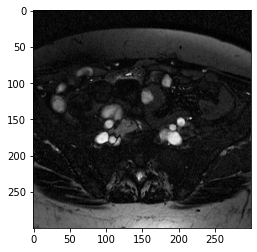

In [ ]:
img_rows, img_cols = 300, 300

#The data, shuffled and split between train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.333, random_state=42)

    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train /= 4095
x_test /= 4095
x_train = x_train[35]
y_train = y_train[4]
x_train = x_train.reshape(1, 300, 300, 1)
y_train = y_train.reshape(1, 2, 1)
#Look at the first 9 images from the dataset
images = range(0, 9)
for i in images:
    # plt.subplot(330 + 1 + i)
    plt.imshow(np.squeeze(x_train), cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

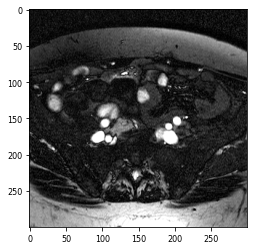

In [ ]:
from skimage import data, img_as_float
from skimage import exposure

# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure

# Load an example image from cifar10 dataset
img = x_train[0]

# Set font size for images
matplotlib.rcParams['font.size'] = 8

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
plt.imshow(np.squeeze(img_rescale.reshape(img_rows, img_cols, 1)), cmap=plt.get_cmap('gray'))

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


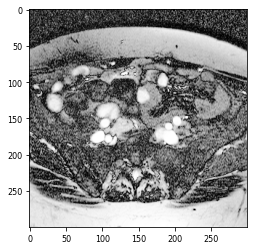

In [ ]:
# Histogram Equalization
# img_eq = exposure.rescale_intensity(img, in_range=(p2, p98))
img_eq = exposure.equalize_hist(img)
plt.imshow(np.squeeze(img_eq.reshape(img_rows, img_cols, 1)), cmap=plt.get_cmap('gray'))

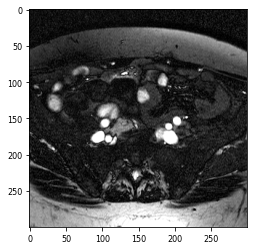

In [ ]:

# Initialize Generator
datagen = ImageDataGenerator(contrast_stretching=True, adaptive_equalization=False, histogram_equalization=False)

# fit parameters from data
datagen.fit(x_train)

# Configure batch size and retrieve one batch of images
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show the first 9 images
    for i in range(0, 9):
        # plt.subplot(330 + 1 + i)
        plt.imshow(np.squeeze(x_batch.reshape(img_rows, img_cols, 1)), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

## Experiment 7 - retrain with augmented data 

In [ ]:
model = Sequential()
model.add(Conv2D(24, kernel_size=5, activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPool2D())
model.add(Conv2D(48, kernel_size=5, activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=5, activation='relu'))
# model.add(MaxPool2D())
# model.add(Conv2D(96, kernel_size=5, activation='relu'))
# model.add(MaxPool2D())
# model.add(Conv2D(128, kernel_size=5, activation='relu'))
# model.add(MaxPool2D())
# model.add(Conv2D(192, kernel_size=5, activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
# model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


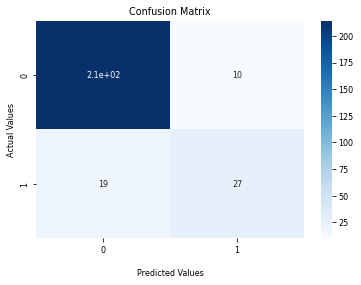

Correct predictions of 1 among all predictions of 1:  0.7297297297297297
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.41304347826086957
F1 Score: 0.6506024096385542
Accuracy: 0.8925925925925926
Cross-validation


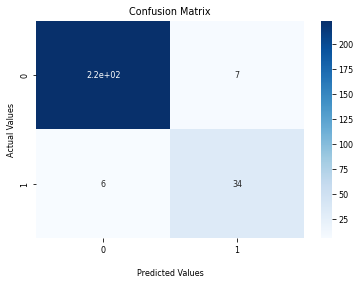

Correct predictions of 1 among all predictions of 1:  0.8292682926829268
Wrong predictions where actual value is 1(predicted 0 where should be 1): 0.15
F1 Score: 0.8395061728395061
Accuracy: 0.9518518518518518
INFO:tensorflow:Assets written to: saved_model/best_model_overall/assets




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.333, random_state=11)

datagen = ImageDataGenerator(contrast_stretching=True, adaptive_equalization=False, histogram_equalization=False)

# fit parameters from data
datagen.fit(X_train)

fitted = model.fit_generator(datagen.flow(X_train, y_train, batch_size=25), epochs = 100, 
                   validation_data = (X_test, y_test), callbacks=[annealer], verbose=0, shuffle=False)

measure_quality(model, X_test, y_test)